# Сборный проект 2

**Описание проекта:**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании.

**Поставлено несколько задач:**

* Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
* Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Задача 1: предсказание уровня удовлетворённости сотрудника

## 1.1. Загрузка данных

Объявим необходмые библиотеки, загрузим датафреймы и выведем их основную информацию:

In [1]:
!pip install shap
!pip install --upgrade shap
!pip install --upgrade scikit-learn
!pip install scikit-learn==1.1.3
!pip install shap -q
!pip install imbalanced-learn
!pip install phik
!pip install seaborn==0.13.2

  Using cached scikit_learn-1.1.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.0
    Uninstalling scikit-learn-1.4.0:
      Successfully uninstalled scikit-learn-1.4.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import statsmodels.stats.outliers_influence as influence
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import make_classification

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC

from imblearn.over_sampling import ADASYN, SMOTENC, SMOTE

import shap
from shap import Explanation, KernelExplainer, TreeExplainer
from shap.plots import waterfall, beeswarm

In [3]:
df1 = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')#, index_col=0)
display(df1)
display(df1.info())

df2 = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')#, index_col=0)
display(df2)
display(df2.info())

df3 = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv', index_col=0)
display(df3)
display(df3.info())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08
...,...
405257,0.28
370925,0.21
857722,0.39


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


None

### Промежуточный вывод:

Данные загружены, соответствуют описанию.


## 1.2. Предобработка данных

Проведём необходимую предобработку данных.

Первый датафрейм:

* неявные дубликаты отсутствуют;
* присутстуют несколько пропусков в столбцах `dept`, `level`. Обработаем их с помощью пайплайна;
* исправим ошибку "sinior" в столбце `level`;
* удалим столбец `id`: в обучающей выборке он не нужен;
* также удалим дубликаты в фичах и, соответственно, целевом параметре.

Аналогичная ситуация во втором датафрейме. Также обнаружен неявный пропуск в столбце `dept`. Заполним его самым частым значением. Столбец `id` преобразуем в индекс.

В обоих датасетах удалим столбец 

Третьему датафрейму предобработка не требуется.


In [4]:
target = df1['job_satisfaction_rate']
features = df1.drop(['job_satisfaction_rate'], axis=1)

cat_columns = ['dept', 'level', 'workload', 'last_year_promo', \
               'last_year_violations']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

cat_pipe = Pipeline(
    [
        ('simpleImputer_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ]
) 

num_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
    ]
)

col_transformer = ColumnTransformer(
    [
        ('cat', cat_pipe, cat_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

df1_imp = col_transformer.fit_transform(features)
df1_res = pd.DataFrame(df1_imp, columns=[x.split('__')[-1] for x in col_transformer.get_feature_names_out()])

df1_res = df1_res.drop('id', axis=1)
df1_res[num_columns] = df1_res[num_columns].astype(int)
df1_res['level'] = df1_res['level'].apply(lambda x: 'senior' if x == 'sinior' else x)

df1_res = df1_res.join(target)
df1_res.drop_duplicates(inplace=True)
target = df1_res['job_satisfaction_rate']
df1_res = df1_res.drop(['job_satisfaction_rate'], axis=1)

df2_imp = col_transformer.transform(df2)
df2_res = pd.DataFrame(df2_imp, columns=[x.split('__')[-1] for x in col_transformer.get_feature_names_out()])

df2_res['dept'] = df2_res['dept'].apply(lambda x: 'sales' if x == " " else x)
df2_res['level'] = df2_res['level'].apply(lambda x: 'senior' if x == 'sinior' else x)
df2_res.index = df2_res['id']
df2_res = df2_res.drop('id', axis=1)
df2_res[num_columns] = df2_res[num_columns].astype(int)


display(df1_res)
display(df1_res.info())
display(df2_res)
display(df2_res.info())

,dept,level,workload,last_year_promo,last_year_violations,employment_years,supervisor_evaluation,salary
0,sales,junior,medium,no,no,2,1,24000
1,hr,junior,high,no,no,2,5,38400
2,sales,junior,low,no,no,1,2,12000
3,technology,junior,low,no,no,4,2,18000
4,hr,junior,medium,no,no,1,3,22800
...,...,...,...,...,...,...,...,...
3993,hr,senior,high,no,no,6,4,80400
3994,sales,junior,medium,no,no,2,3,20400
3997,sales,middle,low,no,no,7,5,24000
3998,sales,junior,medium,no,no,2,3,24000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3752 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   3752 non-null   object
 1   level                  3752 non-null   object
 2   workload               3752 non-null   object
 3   last_year_promo        3752 non-null   object
 4   last_year_violations   3752 non-null   object
 5   employment_years       3752 non-null   int64 
 6   supervisor_evaluation  3752 non-null   int64 
 7   salary                 3752 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 263.8+ KB


None

,dept,level,workload,last_year_promo,last_year_violations,employment_years,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,no,no,2,5,28800
686555,hr,junior,medium,no,no,1,4,30000
467458,sales,middle,low,no,no,5,4,19200
418655,sales,middle,low,no,no,6,4,19200
789145,hr,middle,medium,no,no,5,5,40800
...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,no,no,3,3,20400
109582,technology,middle,low,no,no,3,2,21600
305653,technology,junior,low,no,no,1,3,14400


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   2000 non-null   object
 1   level                  2000 non-null   object
 2   workload               2000 non-null   object
 3   last_year_promo        2000 non-null   object
 4   last_year_violations   2000 non-null   object
 5   employment_years       2000 non-null   int64 
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


None

### Промежуточный вывод:

Проверены все датафреймы:

* полные дубликаты отсутствуют;
* неявные дубликаты отсутствуют;
* исправлены ошибки;
* удалены ненужные столбцы;
* устранены пропуски с помоью пайплайна.

## 1.3. Исследовательский анализ данных

Проведём исследовательский анализ данных из каждой таблицы.

### Первый датафрейм:

Изучим параметры первого датафрейма. Необходимо проверить данные на наличие аномалий и выбросов. Построим гистограммы распределения количественных признаков, а также круговые диаграммы категориальных признаков.

,employment_years
count,3752.00
mean,3.82
median,3.00
max,10.00
min,1.00


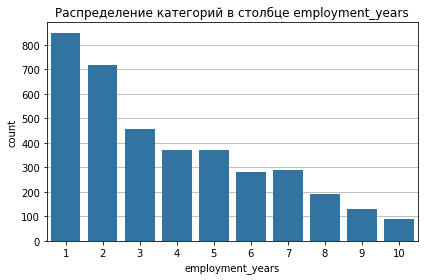

,supervisor_evaluation
count,3752.00
mean,3.46
median,4.00
max,5.00
min,1.00


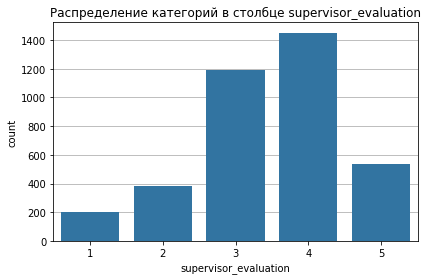

,salary
count,3752.00
mean,34463.22
median,31200.00
max,98400.00
min,12000.00


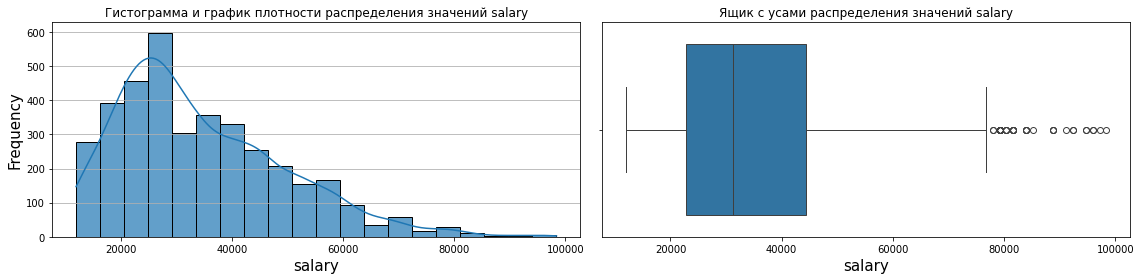

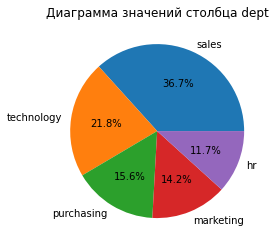

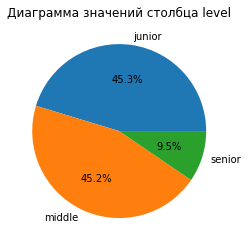

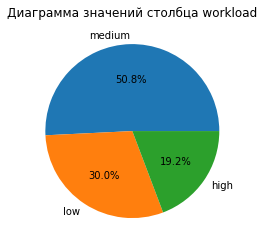

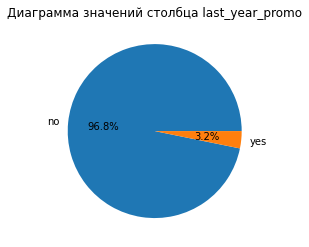

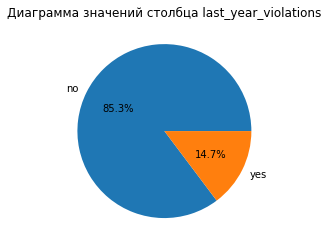

In [5]:
def histogram(data):

    rows = data.select_dtypes(include=['float64', 'int64']).columns
    for i, col in enumerate(rows):
        if col != 'id' and data[col].nunique() > 10:
            f, ax = plt.subplots(1, 2, figsize=(16, 4))
            display(round(data[col].agg(['count', 'mean', 'median', 'max', 'min']), 2).to_frame())
            sns.histplot(x=data[col], kde=True, bins=20, multiple='stack', ax = ax[0], alpha=0.7)
            sns.boxplot(x=data[col], ax = ax[1])
            ax[0].set_title('Гистограмма и график плотности распределения значений {}'.format(col))
            ax[0].set_xlabel(col, fontsize=15)
            ax[0].set_ylabel('Frequency', fontsize=15)          
            ax[0].grid(axis='y')
            ax[1].set_title('Ящик с усами распределения значений {}'.format(col))
            ax[1].set_xlabel(col, fontsize=15)
            plt.tight_layout()
            plt.show()
        elif col != 'id':
            display(round(data[col].agg(['count', 'mean', 'median', 'max', 'min']), 2).to_frame())
            sns.countplot(x=data[col])
            plt.grid(axis='y')
            plt.gca().set_axisbelow(True)
            plt.title('Распределение категорий в столбце {}'.format(col))
            plt.tight_layout()
            plt.show()
                

    for col in data.select_dtypes(include='object').columns:
        plt.pie(x=data[col].value_counts(), labels = data[col].value_counts().index, autopct='%1.1f%%')
        plt.title('Диаграмма значений столбца {}'.format(col))
        plt.show()


histogram(df1_res)

,job_satisfaction_rate
count,3752.00
mean,0.53
median,0.55
max,1.00
min,0.03


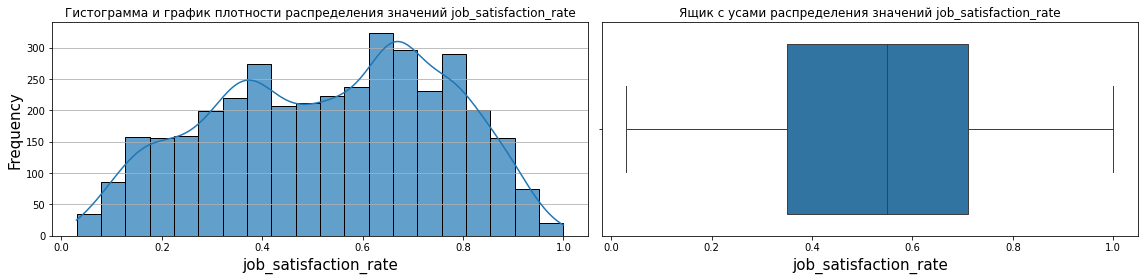

In [6]:
histogram(target.to_frame())

В столбце `employment_years` наблюдается одностороннее нормальное распределение.

В столбце `salary` наблюдаются "сверхдоходные" выбросы. Также можно заметить, что распределение доходов смещено влево относительно среднего значения оси абсцисс графика.

В столбце `job_satisfaction_rate` имеются локальные выбросы (значения 0,4, 0,65 и 0,8). Какие-либо предположения о нарушении нормального распределения сделать трудно, т.к. итоговая оценка выставляется алгоритмами оценки ответов опрашиваемых.

Категориальные значения выглядят корректно.

### Второй датафрейм:

,employment_years
count,2000.00
mean,3.67
median,3.00
max,10.00
min,1.00


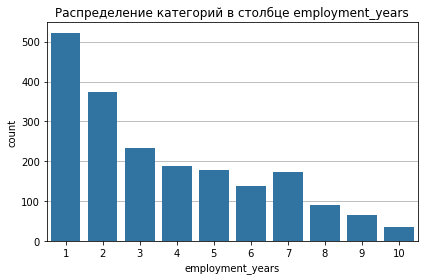

,supervisor_evaluation
count,2000.00
mean,3.53
median,4.00
max,5.00
min,1.00


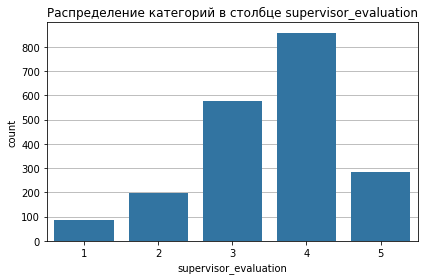

,salary
count,2000.0
mean,34066.8
median,30000.0
max,96000.0
min,12000.0


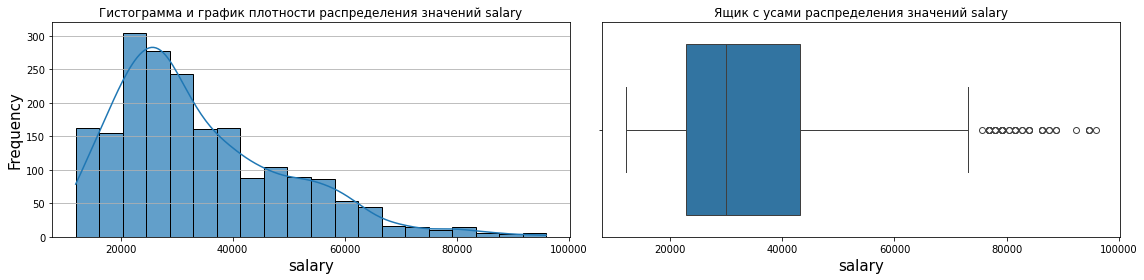

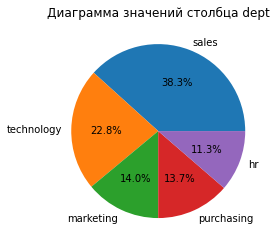

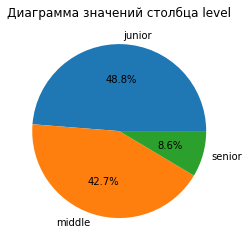

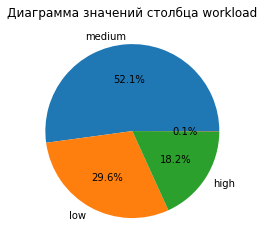

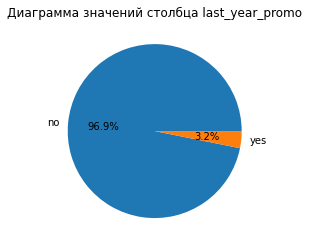

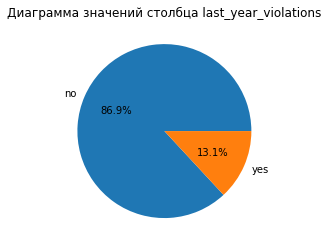

In [7]:
histogram(df2_res)

По графикам второго датафрема можно сделать выводы, аналогичные тем, что были сделаны по второму датафрейму.

### Третий датафрейм:

,job_satisfaction_rate
count,2000.00
mean,0.55
median,0.58
max,1.00
min,0.03


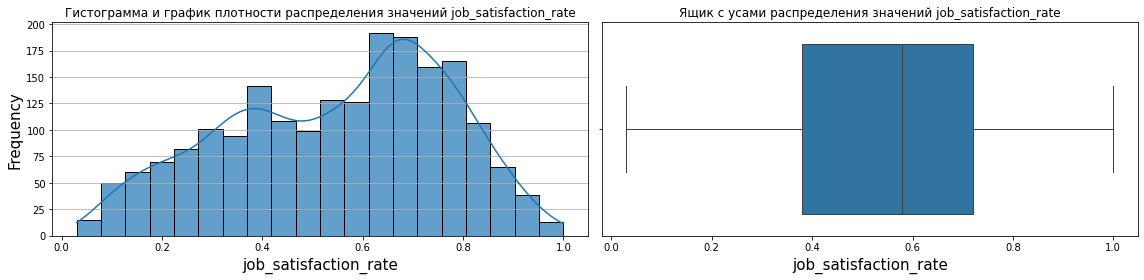

In [8]:
histogram(df3)

Распределение целевого параметра коррелирует с тренировочным датасетом.

### Промежуточный вывод:

каждый датафрейм был проверен на аномальные значения и выбросы. Для всех признаков построены графики распределения параметров, сделано предположение о природе происхождения аномалий.
    
Исследовательский анализ данных завершён.

## 1.4. Корреляционный анализ

Проведём корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования и сделаем выводы о мультиколлинеарности и при необходимости устраним её.

Также построим матрицу корреляции `phik_matrix()` для проверки данных на утечку.

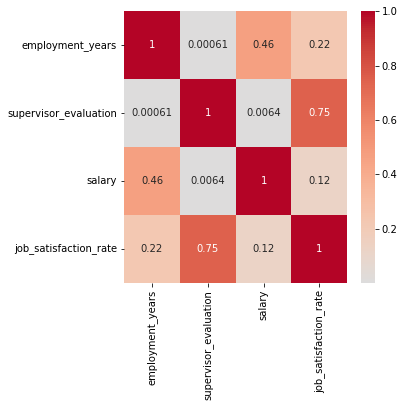

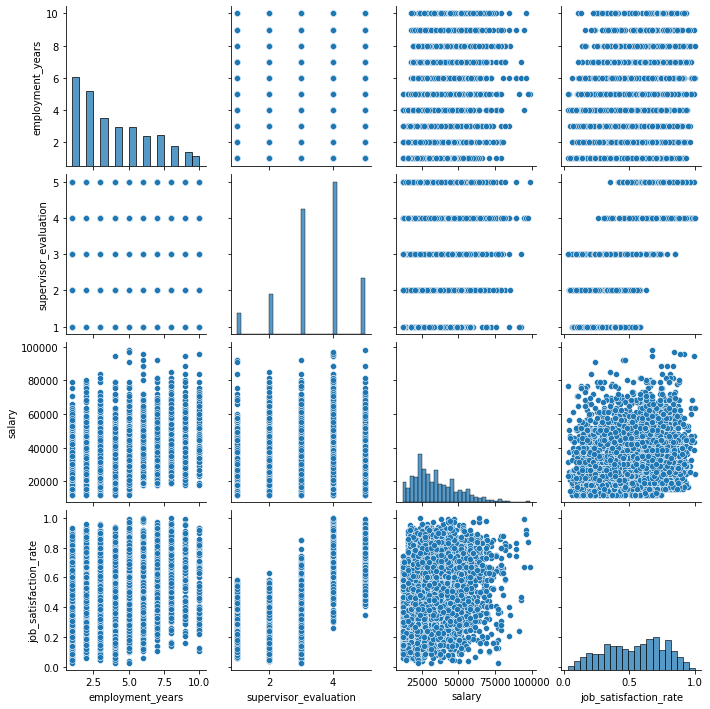

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df1_res.join(target).corr(method='spearman'), annot=True, cmap='coolwarm', center=0)
sns.pairplot(df1_res.join(target))

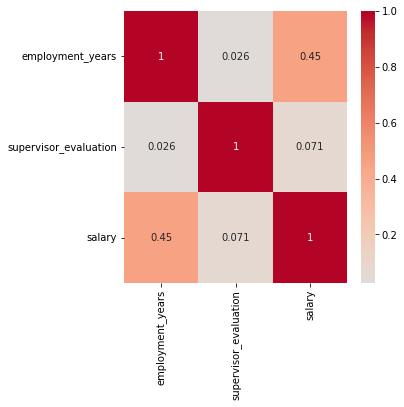

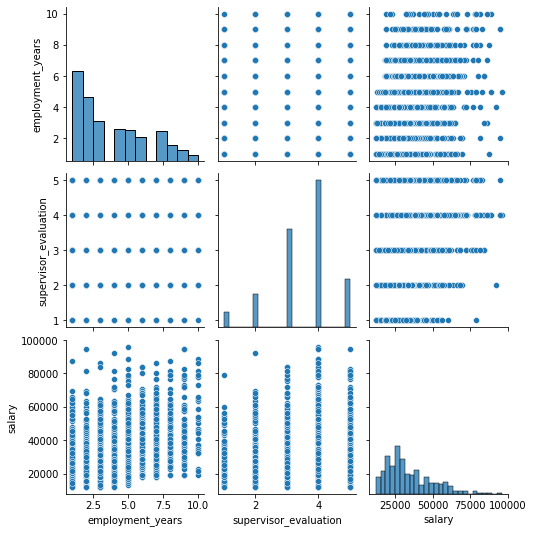

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df2_res.corr(method='spearman'), annot=True, cmap='coolwarm', center=0)
sns.pairplot(df2_res)

Рассчитаем коэффициент инфляции дисперсии (VIF) для определения возможной мультиколлинеарности:

In [11]:
X = df1_res.copy()
X = X.drop(columns=df1_res.select_dtypes(include='object').columns)
X = add_constant(X)
ds=pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
print(round(ds, 2))

X = df2_res.copy()
X = X.drop(columns=df2_res.select_dtypes(include='object').columns)
X = add_constant(X)
ds=pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
print(round(ds, 2))

const                    17.82
employment_years          1.25
supervisor_evaluation     1.00
salary                    1.26
dtype: float64
const                    17.51
employment_years          1.28
supervisor_evaluation     1.01
salary                    1.28
dtype: float64


Мультиколлинеарность отсутствует.

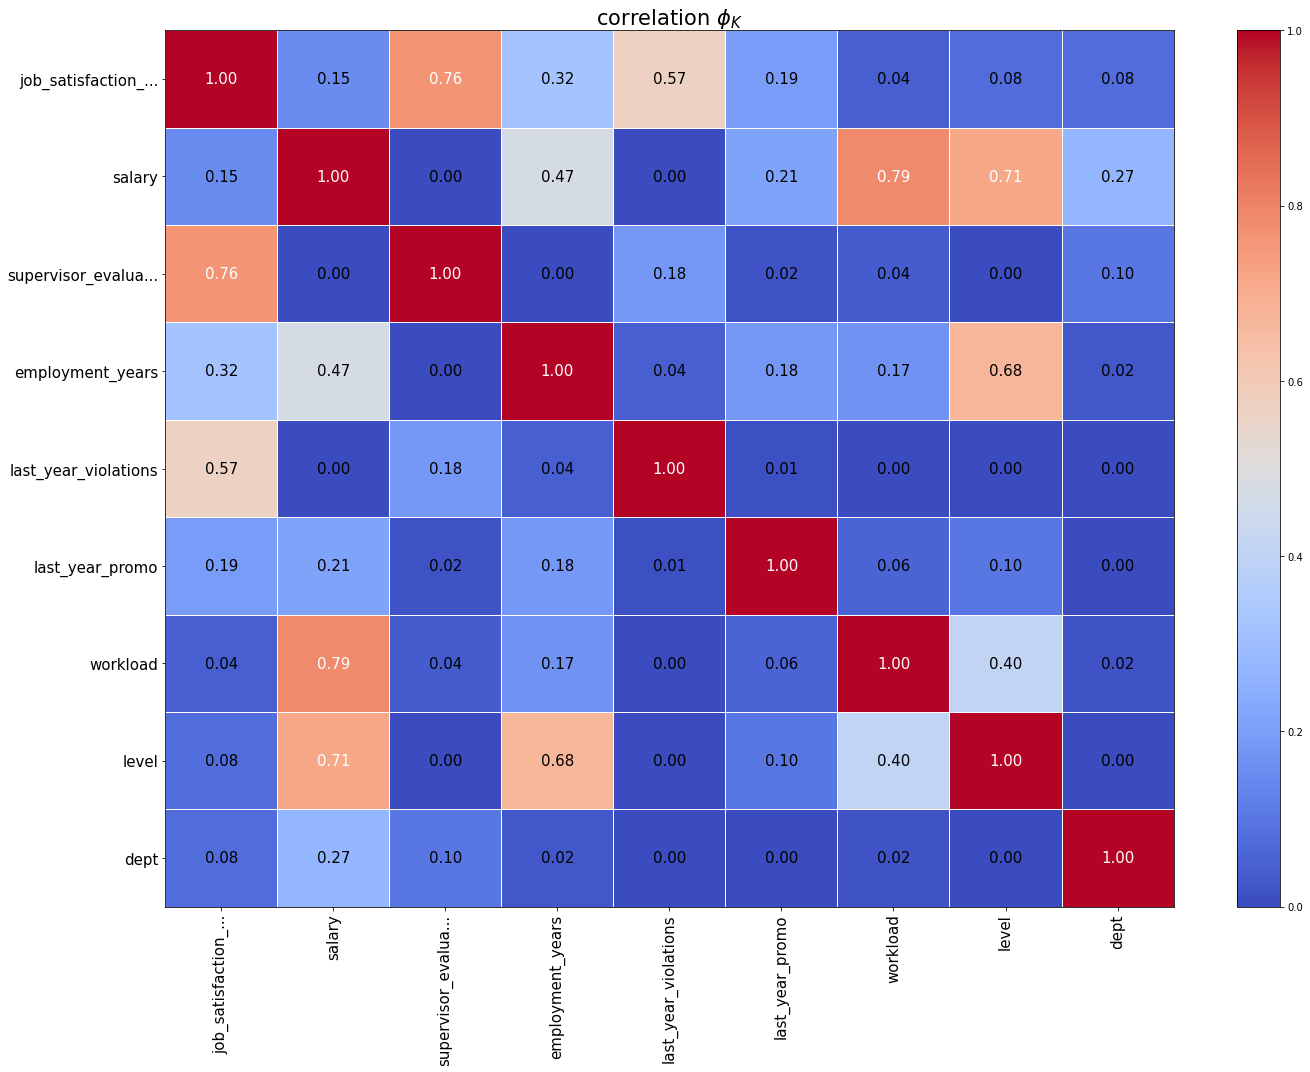

In [12]:
interval_cols = ['salary', 'job_satisfaction_rate']

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df1_res.join(target), interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

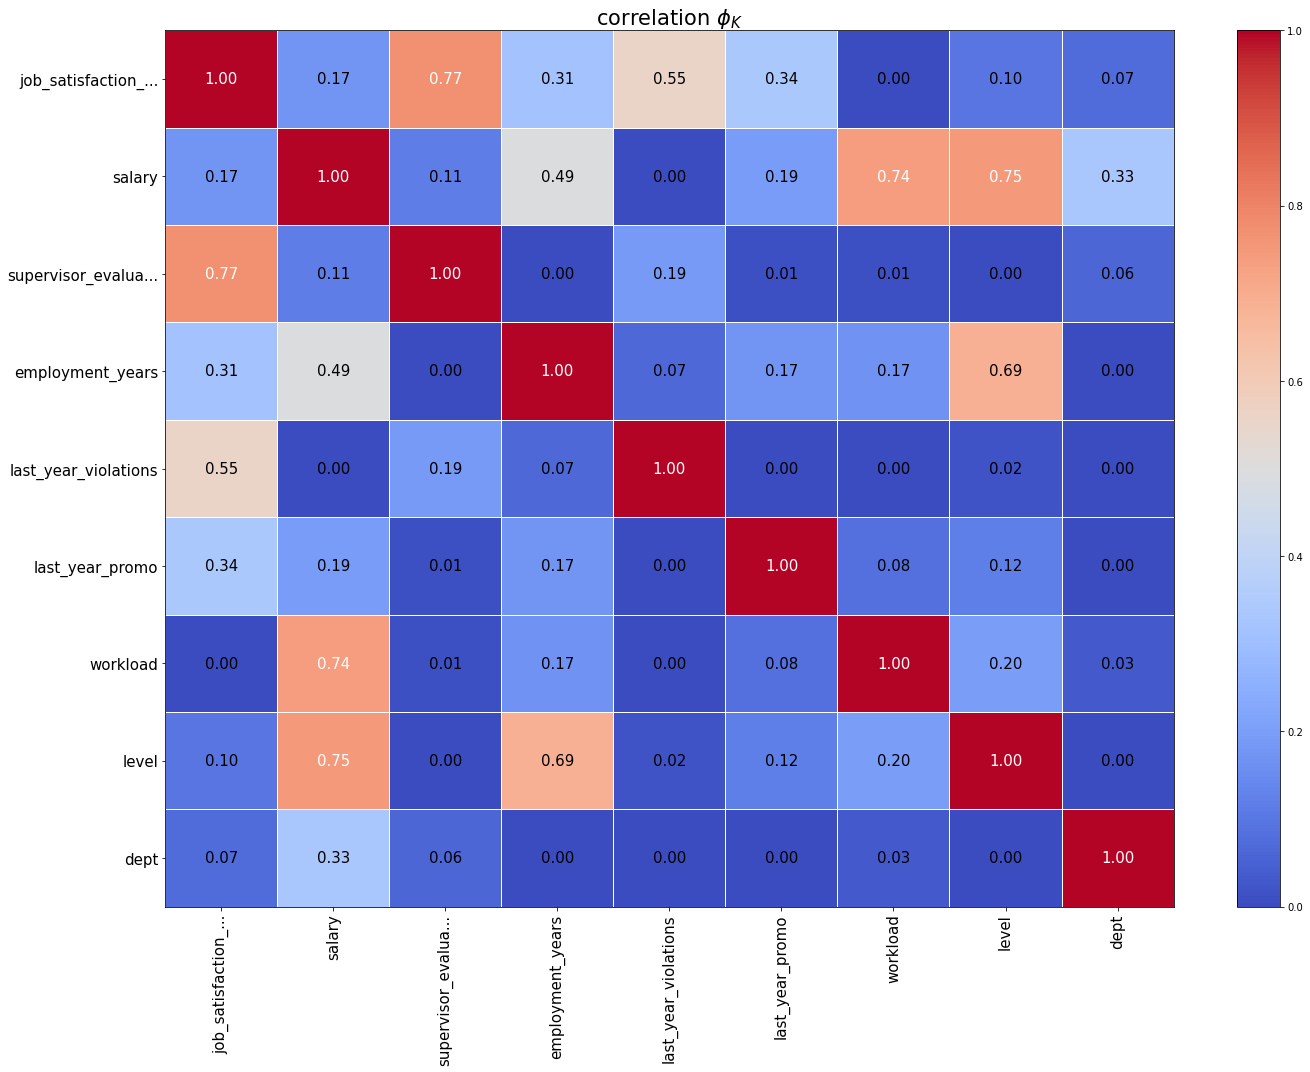

In [13]:
phik_overview = phik_matrix(df2_res.join(df3), interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

### Промежуточный вывод:

По матрице корреляции, тепловой карте и коэффициентам инфляции дисперсии мультиколлинеарность отсутствует.

В ходе исследования матрицы корреляции `phik_matrix()` утечка данных не обнаружена.


## 1.5. Обучение моделей

Обучим две модели: линейную и дерево решений. Также подберём гиперпараметры.

Подготовим данные с помощью `ColumnTransformer`.

Выберем лучшую модель, используя метрику SMAPE.


In [14]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

ohe_columns = ['last_year_violations', 'dept','last_year_promo']
ord_columns = ['level','workload']
num_columns_1 = ['salary']

Функция подсчёта метрики SMAPE:

In [15]:
def smape(y_true, y_pred):
    error = (y_true - y_pred).abs()
    scale = (y_true.abs() + y_pred.__abs__()) / 2

    return (error / scale).mean() * 100

scorer = make_scorer(smape, greater_is_better=False)

### Модель линейной регрессии:

In [16]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[

                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns_1)
    ],
    remainder='passthrough'
)

pipe_final_linear = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

linear = cross_val_score(pipe_final_linear, df1_res, target, cv=5, scoring=scorer) 

print ('Метрика SMAPE линейной модели на кросс-валидации:', round(- linear.mean(), 2))

Метрика SMAPE линейной модели на кросс-валидации: 24.99


### Модель дерева решений:

In [17]:
param_grid_tree = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 15),
        'models__max_features': range(1, 8),        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

pipe_final_tree = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

grid_search_tree = GridSearchCV(
    pipe_final_tree,
    param_grid_tree,
    cv=10,
    scoring=scorer,
    n_jobs=-1
)

grid_search_tree.fit(df1_res, target)

print('Лучшая модель и её параметры:\n\n', grid_search_tree.best_estimator_)
print ('Метрика SMAPE лучшей модели на кросс-валидации:', round(- grid_search_tree.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_violations',
                                                   'dept', 'last_year_promo']),
                                                 ('ord',
                                   

### Промежуточный вывод:

Лучшей моделью оказалась линейная регрессия.

### Проверка модели на тестовом датасете:

In [18]:
df2_res = df2_res.join(df3)

df3 = df2_res['job_satisfaction_rate'].copy()
df2_res.drop('job_satisfaction_rate', axis=1, inplace=True)

df2_pred_tree = grid_search_tree.predict(df2_res)

print(f'Метрика SMAPE на тестовой выборке, регрессия дерева решений: {round(smape(df3, df2_pred_tree), 2)}')

Метрика SMAPE на тестовой выборке, регрессия дерева решений: 14.63


---

## 1.6 Анализ остатков:

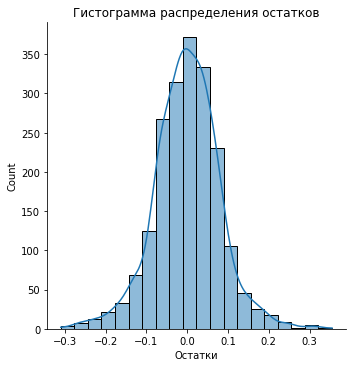

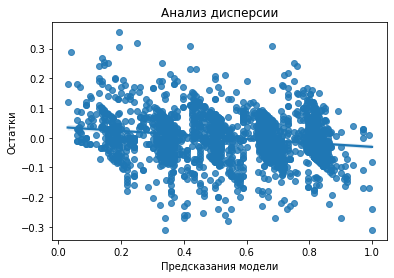

In [19]:
residuals = df3 - df2_pred_tree

sns.displot(residuals, kde=True, multiple='stack', bins=20)
plt.title('Гистограмма распределения остатков')
plt.xlabel('Остатки')
plt.show()

fig, ax = plt.subplots()
sns.regplot(x=df2_pred_tree, y=residuals, fit_reg=True)
plt.xlabel('Предсказания модели')
plt.ylabel('Остатки')
plt.title('Анализ дисперсии')
plt.show()

### Промежуточный вывод:

Среднее значение остатков близко к нулю, дисперсия остатков практически не имеет линейной зависимости от предсказаний.

---

Рассмотрим важность параметров, по которым модель делает прогнозы:

In [20]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(df1_res),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(df2_res),
    columns=data_preprocessor.get_feature_names_out()
)

best_model = grid_search_tree.best_params_['models']
best_model.fit(X_train_p, target)

DecisionTreeRegressor(max_depth=14, max_features=7, random_state=42)

## 1.7 Анализ важности признаков:

Оценим важность признаков для лучшей модели и построим графики важности с помощью метода SHAP.

#### График общей значимости признаков:

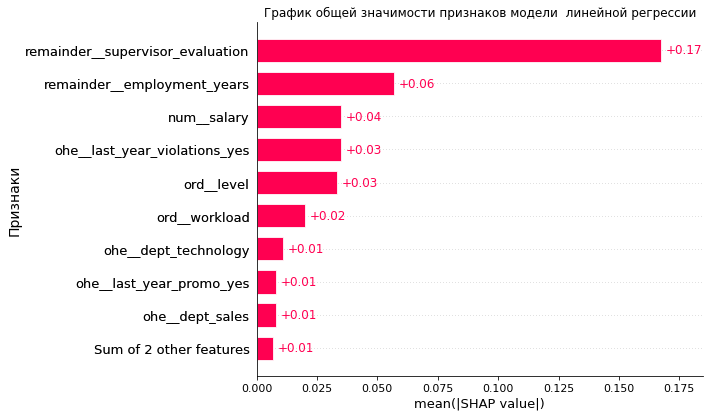

In [21]:
X_train_ = grid_search_tree.best_estimator_.named_steps.preprocessor.fit_transform(df1_res)
model_shap = DecisionTreeRegressor(max_depth=14, max_features=7, random_state=42).fit(X_train_, target)
X_test_ = grid_search_tree.best_estimator_.named_steps.preprocessor.transform(df2_res)
feature_names = grid_search_tree.best_estimator_.named_steps.preprocessor.get_feature_names_out()

# Вычисляем значения SHAP
explainer = shap.Explainer(model_shap, feature_names=feature_names)
shap_values = explainer(X_test_)

# Визуализируем важность признаков
plt.title('График общей значимости признаков модели  линейной регрессии')
plt.ylabel('Признаки', fontsize=14)
shap.plots.bar(shap_values)

#### График вклада признаков в каждое предсказание модели:

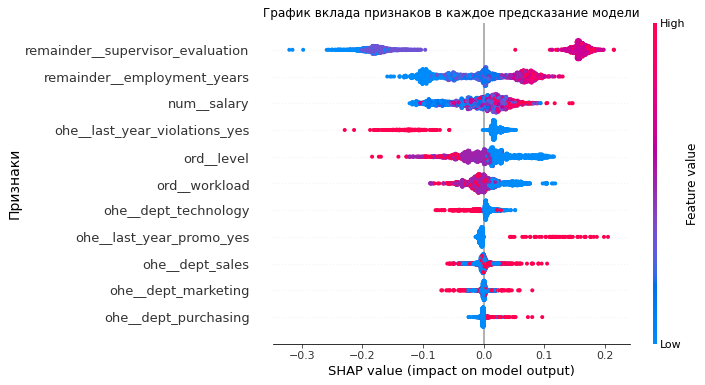

In [22]:
plt.title('График вклада признаков в каждое предсказание модели')
plt.ylabel('Признаки', fontsize=14)
shap.plots.beeswarm(shap_values, max_display=30)

## Выводы по задаче 1:

Была построена модель, которая предсказывает уровень удовлетворённости сотрудника на основе данных заказчика.

Выбор модели сделан на основе метрики SMAPE (symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).

С тестовыми данными лучше всего справилась линейная регрессия.

Анализ важности признаков позволяет дать заказчику следующие рекомендации:

* **ключевыми приизнаками** удовлетворённости сотрудников являются **уровень зарплаты, количество отработанных лет, а также оценка работника руководителем.** Логично, что если труд достойно оплачивается и существуют нематериальные поощрения от руководства, сотрудники будут работать с максимальной отдачей и с малой вероятностью сменят работу. Следует обратить внимание, что **более опытные сотрудники менее всего удовлетворены работой,** необходимо проработать для них дополнительные стимулирующие мероприятия;

* средне удовлетворённость зависит от уровня загруженности сотрудника, стажа работы, нарушений трудового договора работником;

* в то же время, удовлетворённость сотрудников абсолютно не зависит от отдела, в котором они работают. Необходимо отметить, что **повышения в краткосрочной перспективе оказывают положительное влияние,** но из-за незначительного количества таких повышений модель занижает важность данного признака.  

## Задача 2: предсказание увольнения сотрудника из компании

## 2.1. Загрузка данных


In [23]:
df4 = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')#, index_col=0)
display(df4)
display(df4.info())

df5 = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv', index_col=0)
display(df5)
display(df5.info())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes
...,...
836109,yes
180999,yes
746018,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


None

### Промежуточный вывод:

Данные загружены, соответствуют описанию.

## 2.2. Предобработка данных

Проведём необходимую предобработку данных.

Первый датафрейм:

* полные дубликаты присутствуют, но удалять их не будем, т.к. по заданию добавится новый параметр;
* исправим ошибку "sinior" в столбце `level`;
* пропуски и неявные дубликаты отсутствуют.

Второй датафрейм будет взят из первой задачи.

Третьему датафрейму предобработка не требуется.


In [24]:
target_2 = df4['quit']
features_2 = df4.drop(['quit'], axis=1)

df4_imp = col_transformer.transform(features_2)
df4_res = pd.DataFrame(df4_imp, columns=[x.split('__')[-1] for x in col_transformer.get_feature_names_out()])

df4_res = df4_res.drop('id', axis=1)
df4_res[num_columns] = df4_res[num_columns].astype(int)
df4_res['level'] = df4_res['level'].apply(lambda x: 'senior' if x == 'sinior' else x)

df4_res = df4_res.join(target_2)
df4_res.drop_duplicates(inplace=True)
target_2 = df4_res['quit']
df4_res = df4_res.drop(['quit'], axis=1)

display(df4_res)
display(df4_res.info())

,dept,level,workload,last_year_promo,last_year_violations,employment_years,supervisor_evaluation,salary
0,sales,middle,high,no,no,2,4,54000
1,sales,junior,medium,no,no,2,4,27600
2,purchasing,middle,medium,no,no,5,1,37200
3,sales,junior,medium,no,yes,2,3,24000
4,marketing,junior,medium,no,no,2,5,25200
...,...,...,...,...,...,...,...,...
3991,technology,junior,low,no,no,2,4,22800
3992,marketing,junior,low,no,no,1,5,18000
3994,technology,junior,high,no,no,1,4,42000
3997,purchasing,junior,low,no,yes,2,4,12000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 0 to 3998
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   2587 non-null   object
 1   level                  2587 non-null   object
 2   workload               2587 non-null   object
 3   last_year_promo        2587 non-null   object
 4   last_year_violations   2587 non-null   object
 5   employment_years       2587 non-null   int64 
 6   supervisor_evaluation  2587 non-null   int64 
 7   salary                 2587 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 181.9+ KB


None

## 2.3. Исследовательский анализ данных

Проведём исследовательский анализ данных из каждой таблицы.

### Первый датафрейм:

Изучим параметры первого датафрейма. Необходимо проверить данные на наличие аномалий и выбросов. Построим гистограммы распределения количественных признаков, а также круговые диаграммы категориальных признаков.

,employment_years
count,2587.00
mean,4.21
median,4.00
max,10.00
min,1.00


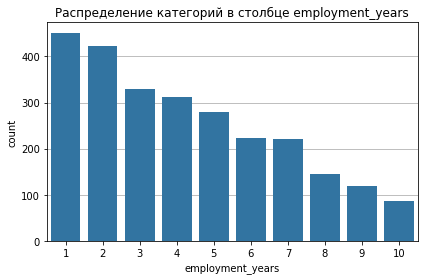

,supervisor_evaluation
count,2587.00
mean,3.37
median,3.00
max,5.00
min,1.00


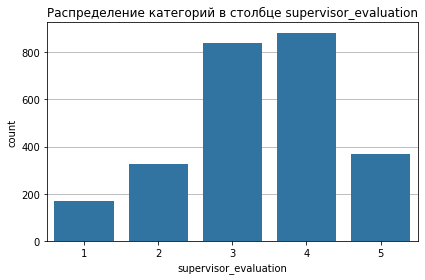

,salary
count,2587.00
mean,37107.69
median,33600.00
max,96000.00
min,12000.00


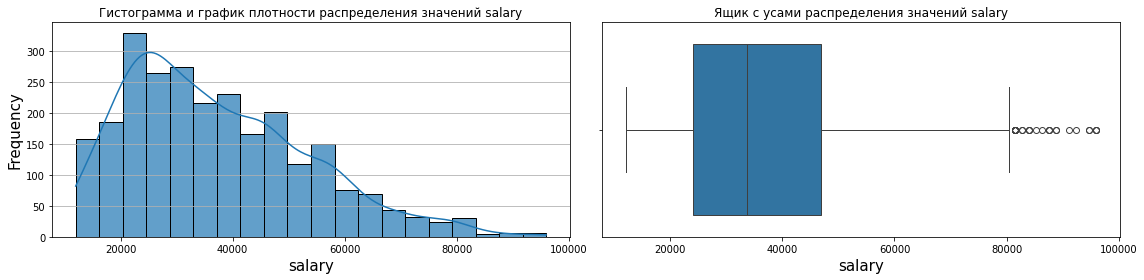

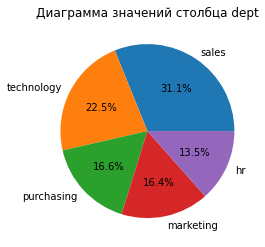

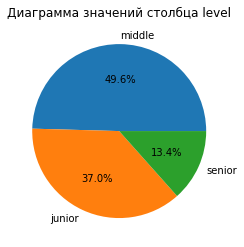

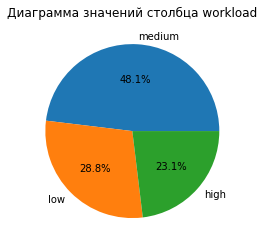

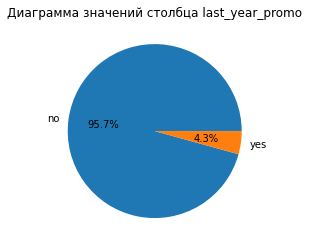

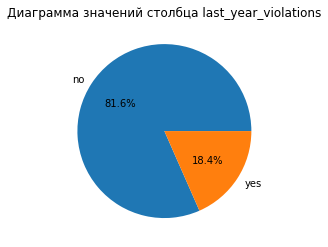

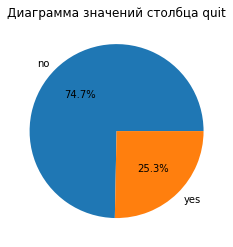

In [25]:
histogram(df4_res.join(target_2))

В столбце `employment_years` наблюдается одностороннее нормальное распределение.

В столбце `salary` наблюдаются "сверхдоходные" выбросы. Также можно заметить, что распределение доходов смещено влево относительно среднего значения оси абсцисс графика.

Категориальные значения выглядят корректно.

### Третий датафрейм:

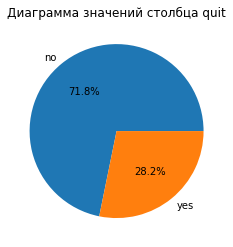

In [26]:
histogram(df5)

Категориальные значения выглядят корректно.

### Промежуточный вывод:

Каждый датафрейм был проверен на аномальные значения и выбросы. Для кадого признака было сделано предположение о природе происхождения аномалий.
    
Исследовательский анализ данных завершён.

### Составим портрет «уволившегося сотрудника»:

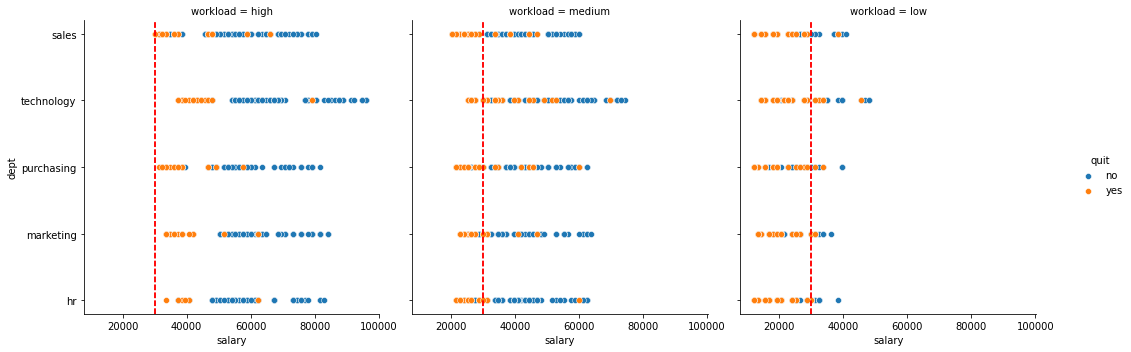

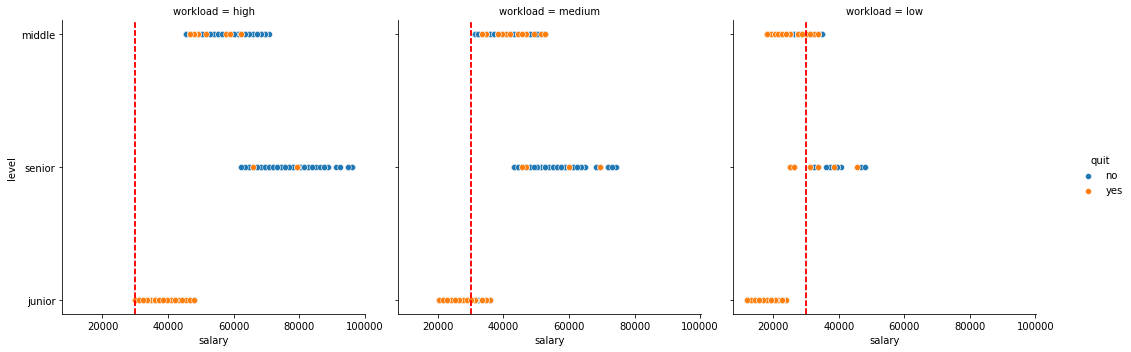

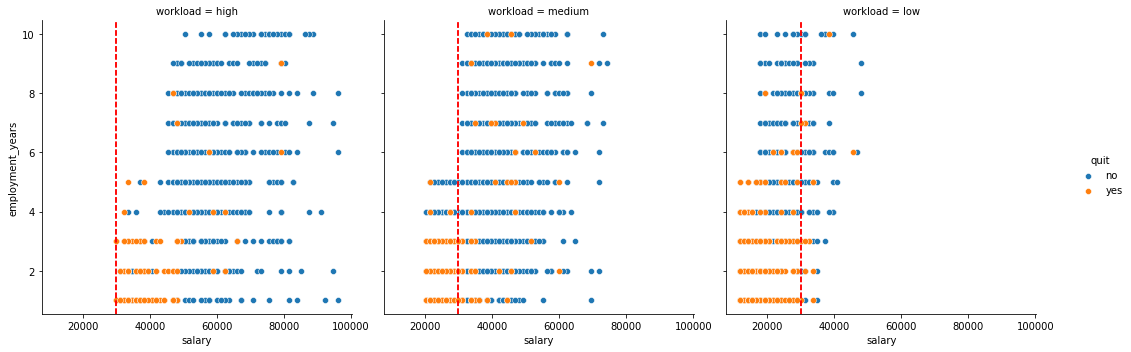

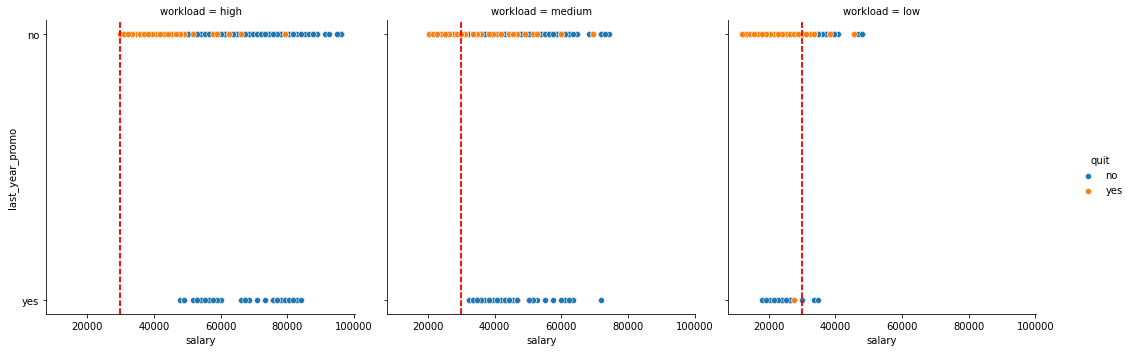

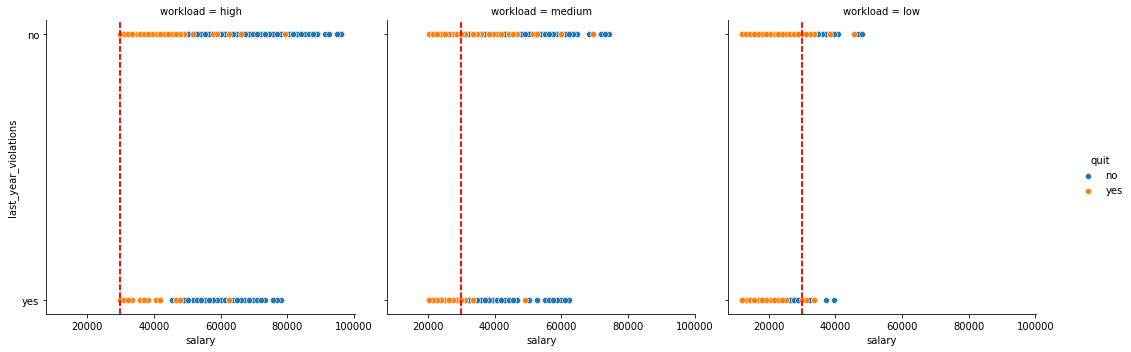

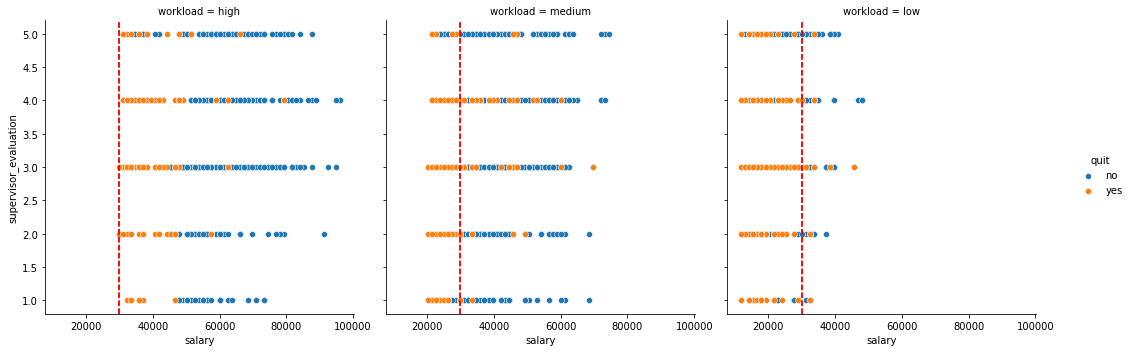

In [27]:
for row in ['dept', 'level', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']:
    g = sns.FacetGrid(data=df4_res.join(target_2), col='workload', hue='quit', height=5, aspect=1)
    g.map(sns.scatterplot, 'salary', row)
    g.add_legend()
    g.refline(x=df4['salary'].median(), linestyle='--', color='red')

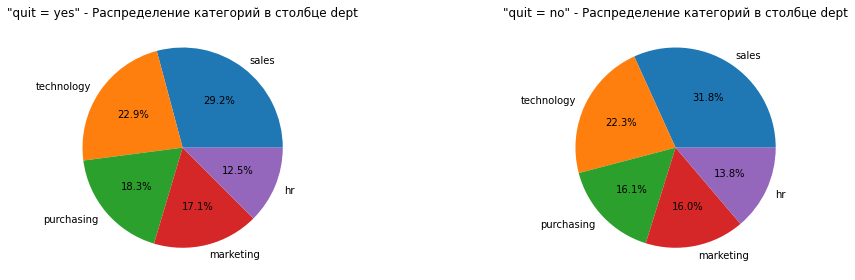

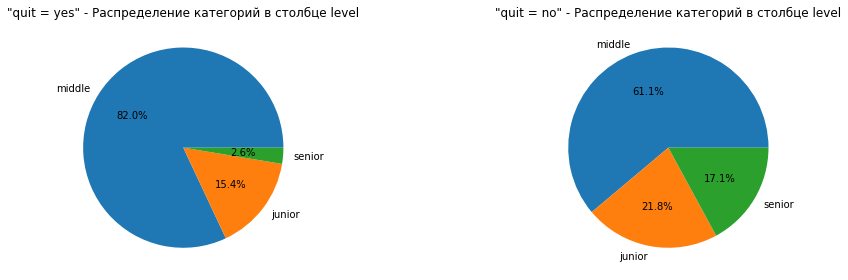

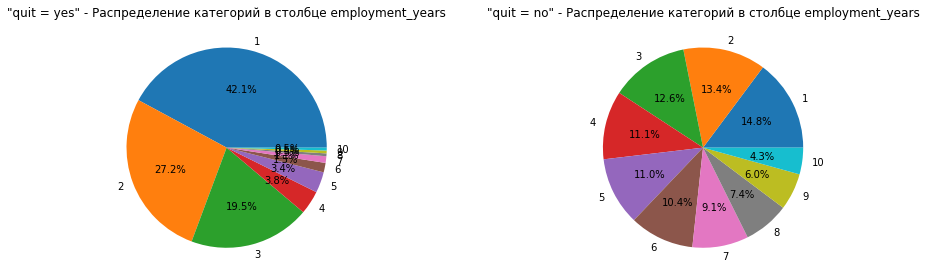

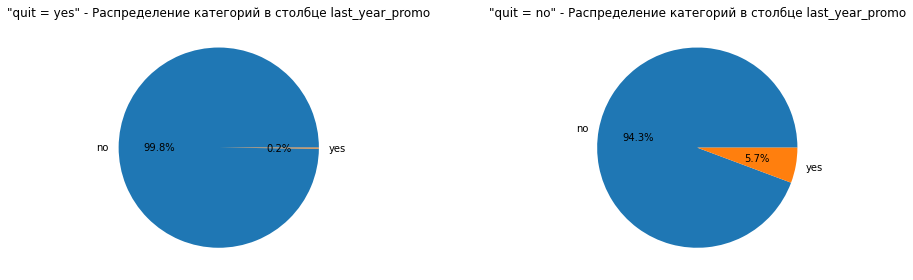

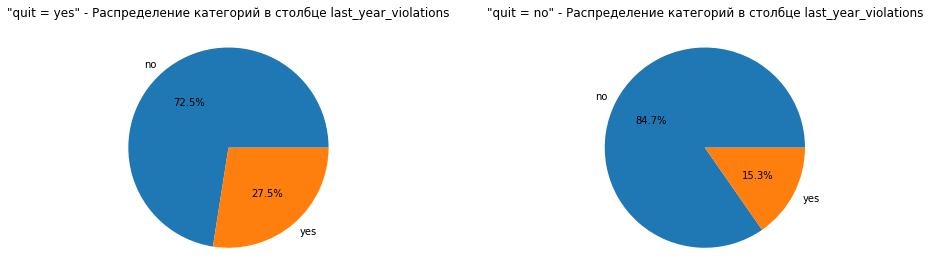

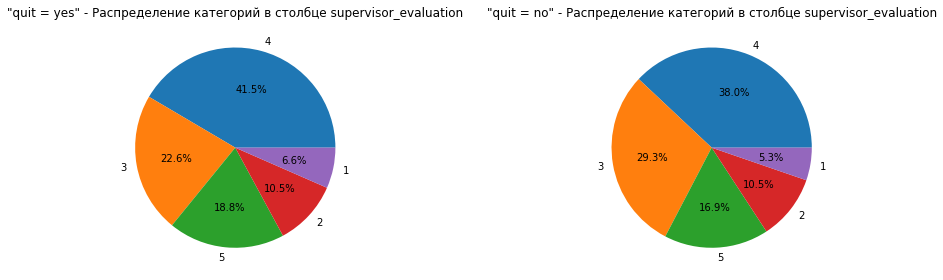

In [28]:
def pirog(data):

    rows = ['dept', 'level', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
    data_yes = data.query('quit == "yes"')
    data_no = data.query('quit == "no"')
    for i, col in enumerate(rows):
        f, ax = plt.subplots(1, 2, figsize=(16, 4))
        ax[0].pie(x=data_yes[col].value_counts(), labels = data[col].value_counts().index, autopct='%1.1f%%')
        ax[1].pie(x=data_no[col].value_counts(), labels = data[col].value_counts().index, autopct='%1.1f%%')
        ax[0].set_title('"quit = yes" - Распределение категорий в столбце {}'.format(col))
        ax[1].set_title('"quit = no" - Распределение категорий в столбце {}'.format(col))
        plt.tight_layout()
        plt.show()

pirog(df4_res.join(target_2))

### Промежуточный вывод:

По данным графикам можно сделать следующие предположения:

* подтверждается тезис о сильном влиянии заработной платы на вероятность увольнения сотрудника: **подавляющее большинство ушедших сотрудников получали зарплату ниже медианной;**



* уволились почти все новички, а также более опытные сотрудники, которые были средне или мало загружены работой;

* очевидно, что подавляющее большинство уволившихся сотрудников имело стаж работы 5 лет и менее;

* **практически всем уволившимся сотрудникам не давали повышение;**

* по отделам, нарушениям/не наружениям трудового договора, а также оценкам руководителей наблюдаются равномерные распределения увольнений.

**Итоговый портрет уволившегося сотрудника:** зарплата меньше медианной, не повышали по службе, без опыта или со средним опытом, но с малой рабочей нагрузкой, стаж работы 5 лет и менее.

### Проверка предположения аналитиков:

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Визуализируем и сравним распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

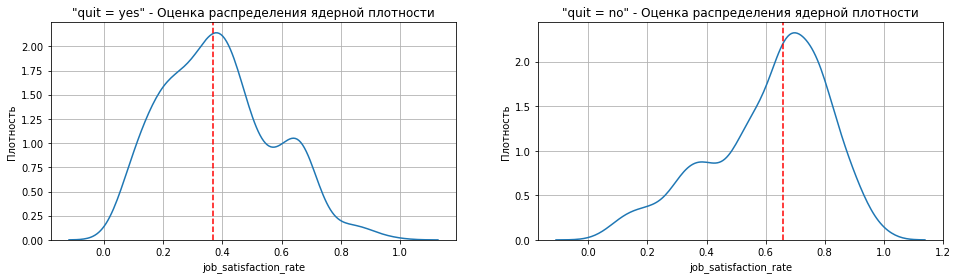

In [29]:
df_job = df3.to_frame().join(df5, how='outer')

f, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.kdeplot(data=df_job.query('quit == "yes"'), x='job_satisfaction_rate', ax=ax[0], common_grid=True)
ax[0].grid(True)
ax[0].set_title('"quit = yes" - Оценка распределения ядерной плотности')
ax[0].axvline(x=df_job.query('quit == "yes"')['job_satisfaction_rate'].median(), linestyle='--', color='red')
ax[0].set_ylabel('Плотность')

sns.kdeplot(data=df_job.query('quit == "no"'), x='job_satisfaction_rate', ax=ax[1])
ax[1].set_title('"quit = no" - Оценка распределения ядерной плотности')
ax[1].grid(True)
ax[1].axvline(x=df_job.query('quit == "no"')['job_satisfaction_rate'].median(), linestyle='--', color='red')
ax[1].set_ylabel('Плотность')
plt.show()


### Промежуточный вывод:

Обнаружена связь между оценкой удовлетворённости и увольнениями: 

* среди тех, кто уволился, оценка удовлетворённости стремится к значению ~0,35;
* те же, кто остался, удовлетворены лучше: их оценка стремится к значению ~0,70.

На обоих графиках обнаружены локальные пики. Можно сделать предположение, что данная ситуация обусловлена взаимовлиянием этих распределений.

Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [30]:
ohe_columns = ['last_year_violations', 'dept', 'last_year_promo','last_year_violations']
ord_columns = ['level','workload']
num_columns_2 = ['salary', 'job_satisfaction_rate']

X_test_p = pd.DataFrame(
    data_preprocessor.fit_transform(df4_res),
    columns=data_preprocessor.get_feature_names_out()
)

df4_pred_tree = grid_search_tree.predict(df4_res)

df4_res['job_satisfaction_rate'] = df4_pred_tree
df4_res[num_columns] = df4_res[num_columns].astype(int)
display(df4_res)

df2_res['job_satisfaction_rate'] = df2_pred_tree
display(df2_res)

,dept,level,workload,last_year_promo,last_year_violations,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,no,no,2,4,54000,0.65000
1,sales,junior,medium,no,no,2,4,27600,0.83800
2,purchasing,middle,medium,no,no,5,1,37200,0.38000
3,sales,junior,medium,no,yes,2,3,24000,0.38000
4,marketing,junior,medium,no,no,2,5,25200,0.69000
...,...,...,...,...,...,...,...,...,...
3991,technology,junior,low,no,no,2,4,22800,0.84381
3992,marketing,junior,low,no,no,1,5,18000,0.86000
3994,technology,junior,high,no,no,1,4,42000,0.54000
3997,purchasing,junior,low,no,yes,2,4,12000,0.56000


,dept,level,workload,last_year_promo,last_year_violations,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,no,no,2,5,28800,0.885000
686555,hr,junior,medium,no,no,1,4,30000,0.668889
467458,sales,middle,low,no,no,5,4,19200,0.654000
418655,sales,middle,low,no,no,6,4,19200,0.655000
789145,hr,middle,medium,no,no,5,5,40800,0.816071
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,no,no,3,3,20400,0.482195
109582,technology,middle,low,no,no,3,2,21600,0.100000
305653,technology,junior,low,no,no,1,3,14400,0.240000


## 2.4. Корреляционный анализ

Проведём корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования и сделаем выводы о мультиколлинеарности и при необходимости устраним её.

Также построим матрицу корреляции `phik_matrix()` для проверки данных на утечку.

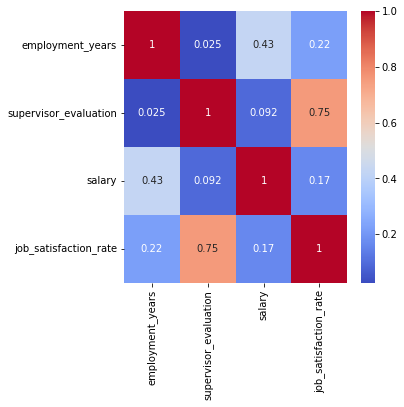

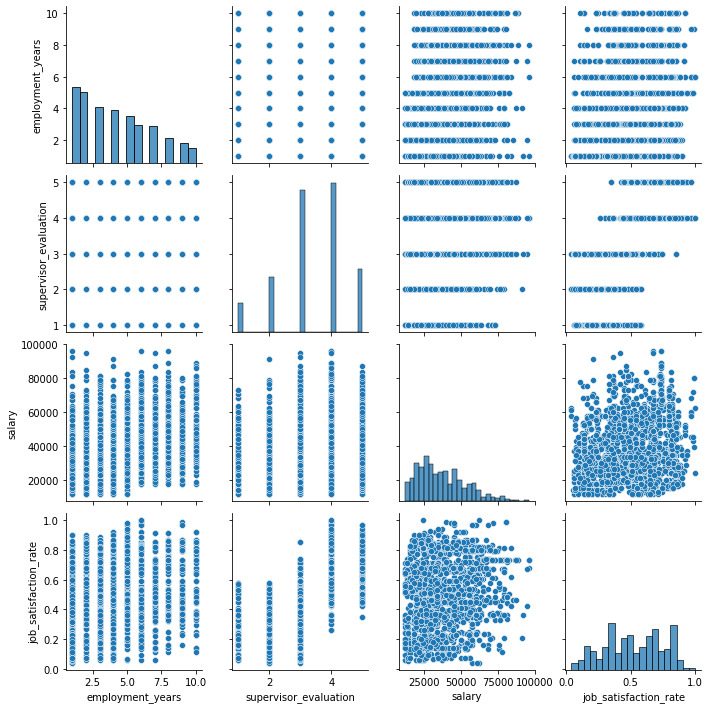

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df4_res.corr(method='spearman'), annot=True, cmap='coolwarm')
sns.pairplot(df4_res)

Рассчитаем коэффициент инфляции дисперсии (VIF) для определения возможной мультиколлинеарности:

In [32]:
X = df4_res.copy()
X = X.drop(columns=df4_res.select_dtypes(include='object').columns)
X = add_constant(X)
ds=pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
print(round(ds, 2))

const                    15.37
employment_years          1.28
supervisor_evaluation     2.04
salary                    1.21
job_satisfaction_rate     2.14
dtype: float64


При добавлении предсказанного параметра мультиколлинеарность не наблюдается.

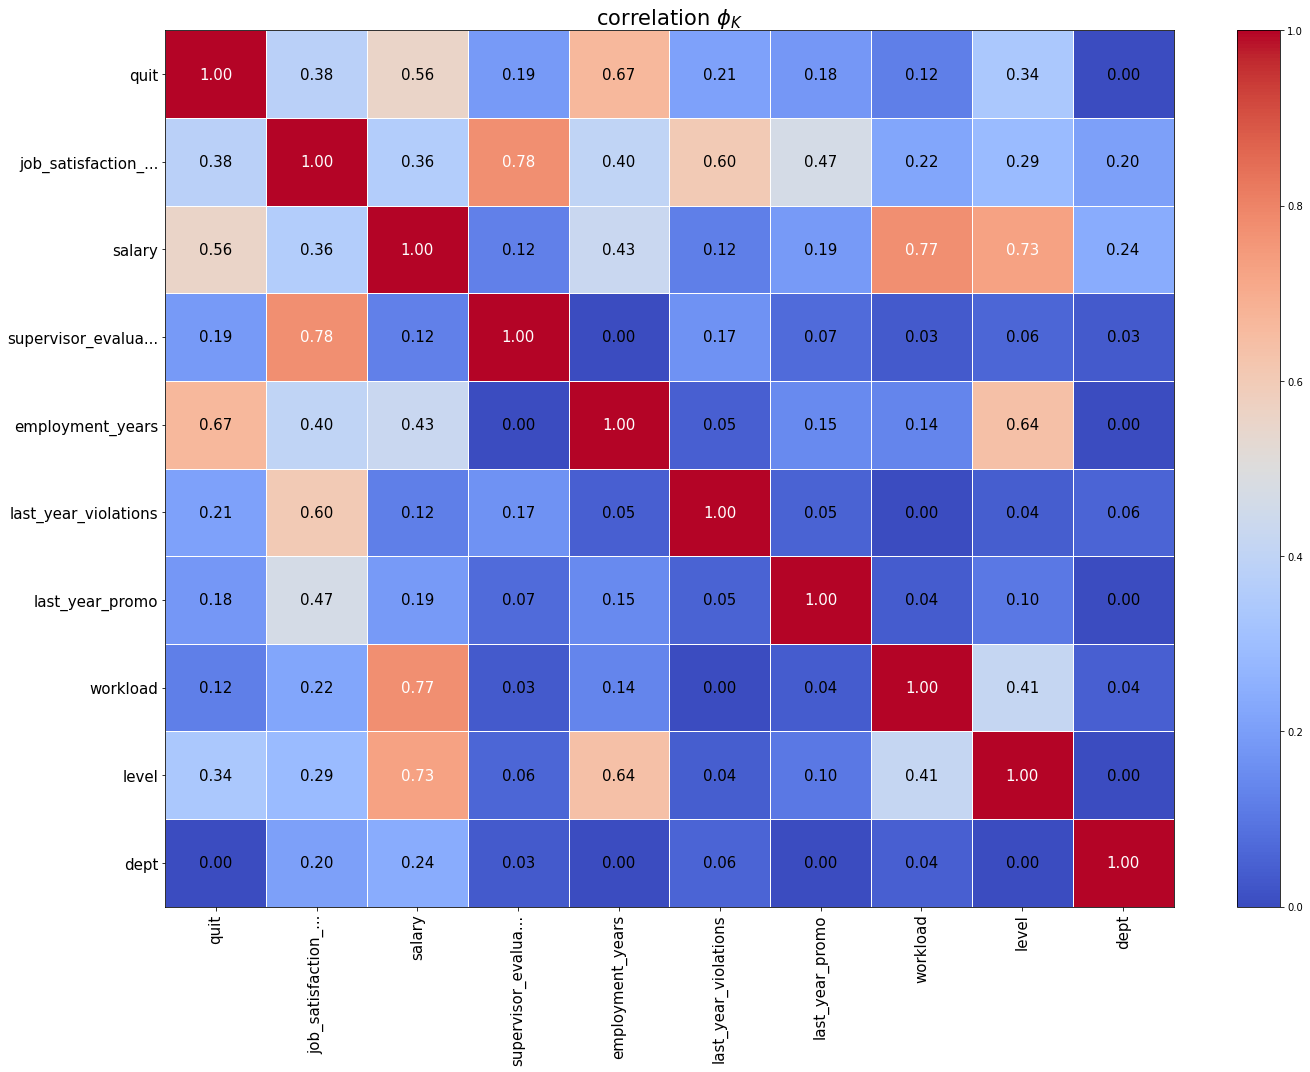

In [33]:
interval_cols = ['salary', 'job_satisfaction_rate']

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df4_res.join(target_2), interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

### Промежуточный вывод:

По матрице корреляции, тепловой карте и коэффициентам инфляции дисперсии мультиколлинеарность не наблюдается.

В ходе исследования матрицы корреляции `phik_matrix()` утечка данных не обнаружена.


## 2.5. Обучение моделей

С помощью пайплайнов подберём наиболее точную модель.

Подготовим данные с помощью `ColumnTransformer`.

Выбирать будем из четырёх моделей: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и  `SVC()`.

Для каждой из них подберём гиперпараметры, а также выберем подходящую для подбора метрику.

Также устраним дисбаланс классов.

Выберем лучшую модель, используя метрику `roc_auc`.

In [34]:
ohe_columns = ['last_year_violations', 'dept', 'last_year_promo','last_year_violations']
ord_columns = ['level','workload']
num_columns_2 = ['salary', 'job_satisfaction_rate']

ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns_2)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 6),
        'models__max_features': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        'models__degree': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(df4_res, target_2)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(grid_search.best_score_, 4))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_violations',
                                                   'dept', 'last_year_promo',
                                                   'last_year_violations']),
                 

### Промежуточный вывод:

Лучшей моделью является `SVC(degree=2, kernel='poly', probability=True, random_state=42))`.

Построим ConfusionMatrix:

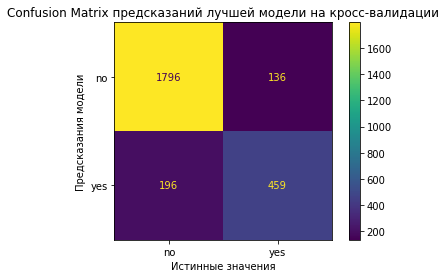

In [35]:
ConfusionMatrixDisplay.from_estimator(grid_search, df4_res, target_2)
plt.title('Confusion Matrix предсказаний лучшей модели на кросс-валидации')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказания модели')
plt.show()

Количество предсказанных истинных значений `yes` (TP) и `no` (TN) составляет 459 и 1796 соответственно. Всего 87%

Количество ошибочно предсказанных значений `yes` (FP) и `no` (FN) составляет 196 и 136 соответственно. Всего 13%.

### Проверка моделей на тестовом датасете:

In [36]:
df2_res = df2_res.join(df5)

df5 = df2_res['quit'].copy()
df2_res.drop('quit', axis=1, inplace=True)

df2_pred_proba = grid_search.predict_proba(df2_res)[:,1]
df2_pred = grid_search.predict(df2_res)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(df5, df2_pred_proba), 4)}')

f1 = f1_score(df5, df2_pred, average='macro')
print('F1-score =', round(f1,2))

Метрика ROC-AUC на тестовой выборке: 0.9118
F1-score = 0.84


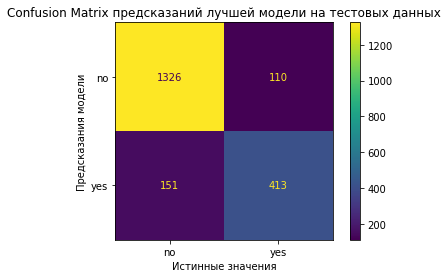

In [37]:
ConfusionMatrixDisplay.from_estimator(grid_search, df2_res, df5)
plt.title('Confusion Matrix предсказаний лучшей модели на тестовых данных')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказания модели')
plt.show()

Количество предсказанных истинных значений `yes` (TP) и `no` (TN) составляет 413 и 1326 соответственно. Всего 87%.

Количество ошибочно предсказанных значений `yes` (FP) и `no` (FN) составляет 151 и 110 соответственно. Всего 13%.

## Общий вывод:

**Описание проекта:**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании.

**Поставлено несколько задач:**

* Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
* Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Исходные данные:** в нашем распоряжении несколько датафреймов.

В первом датафрейме содержится информация о сотрудниках:
```
id — уникальный идентификатор сотрудника;
dept — отдел, в котором работает сотрудник;
level — уровень занимаемой должности;
workload — уровень загруженности сотрудника;
employment_years — длительность работы в компании (в годах);
last_year_promo — показывает, было ли повышение за последний год;
last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
salary — ежемесячная зарплата сотрудника;
job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

```

Остальные представляют собой тестовые данные для обкатки модели, данные в них идентичны.

**В ходе предобработки исходных данных было сделано:**

* данные проверены на наличие дубликатов - оставлены, т.к. это разные сотрудники;
* исправлены неявные дубликаты  и пропуски.

**В ходе исследовательского анализа данных было сделано:**

каждый датафрейм был проверен на аномальные значения и выбросы. Для кадого признака было сделано предположение о природе происхождения аномалий, в первом и втором датафреймах аномально высокие зарплаты были удалены. А из третьего были отфильтрованы удалённые позиции из второго датафрейма.

**Корреляционный анализ данных показал:**

По матрице корреляции, тепловой карте и коэффициентам инфляции дисперсии мультиколлинеарность отсутствует.

В ходе исследования матрицы корреляции `phik_matrix()` утечка данных не обнаружена.

**Были обучены модели:** `LinearRegression()` и  `DecisionTreeRegressor()`.

Лучшая модель определена с помощью метрики `SMAPE`.

**С тестовыми данными лучше всего справилась линейная регрессия.**

**Произведён анализ остатков:** Среднее значение остатков близко к нулю. Дисперсия остатков имеет линейную зависимость: наименьшие значения остатков получаются при предсказании удовлетворённости около 50%. Чем ближе модель делает предсказания к 0% или 100%, тем остатки больше.

**Оценены важности признаков для лучшей модели и построены графики важности с помощью метода SHAP.**

Менее всего значимы для модели признаки:

* Выручка за текущий месяц обсолютно не влияет на модель (вес признака 0,0);
* количество маркетинговых коммуникаций, категории товара, выручка за прошлые месяцы, время с момента регистрации, ошибки сервиса и рассылка покупателям дополнительных предложений о товаре влияют на работу модели незначительно (вес признаков менее 0,2);

Анализ важности признаков позволяет дать заказчику следующие рекомендации:

* **ключевыми приизнаками** удовлетворённости сотрудников являются **уровень зарплаты, занимаемая должность, а также оценка работника руководителем;**

* средне удовлетворённость зависит от уровня загруженности сотрудника, стажа работы, нарушений трудового договора работником;

* удовлетворённость сотрудников абсолютно не зависит от отдела, в котором они работают.

---

**Задача 2:**

Во второй задаче помимо стандартного исследовательского анализа данных необходимо было составить портрет "уволившегося сотрудника" и проверить предположение аналитиков, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.


**Итоговый портрет уволившегося сотрудника:** зарплата меньше медианной, не повышали по службе, без опыта или со средним опытом, но с малой рабочей нагрузкой, стаж работы 5 лет и менее.

По данным матрицы корреляции `phik_matrix()` **обнаружена умеренная связь между оценкой удовлетворённости и увольнениями.**

**Были обучены четыре модели:** `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и  `SVC()`.

Для каждой из них подбраны гиперпараметры, устранён дисбаланс классов. Лучшая модель определена с помощью метрики `roc_auc`.

**Лучшей моделью является `SVC(degree=2, kernel='poly', probability=True, random_state=42))** метрика `roc_auc` установилась на значении 0,91.


Анализ важности признаков позволяет дать заказчику следующие рекомендации:

* **ключевыми приизнаками** удовлетворённости сотрудников являются **уровень зарплаты, количество отработанных лет, а также оценка работника руководителем.** Логично, что если труд достойно оплачивается и существуют нематериальные поощрения от руководства, сотрудники будут работать с максимальной отдачей и с малой вероятностью сменят работу. Следует обратить внимание, что **более опытные сотрудники менее всего удовлетворены работой,** необходимо проработать для них дополнительные стимулирующие мероприятия;

* средне удовлетворённость зависит от уровня загруженности сотрудника, стажа работы, нарушений трудового договора работником;

* в то же время, удовлетворённость сотрудников абсолютно не зависит от отдела, в котором они работают. Необходимо отметить, что **повышения в краткосрочной перспективе оказывают положительное влияние,** но из-за незначительного количества таких повышений модель занижает важность данного признака.  